<a href="https://colab.research.google.com/github/burgauss/RL_ControlPurposes/blob/main/10062021_buju_OneQuadrantConverter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tf-agents

In [ ]:
pip install gym

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

from scipy import signal, misc
import scipy.signal as signal

import matplotlib
import matplotlib.pyplot as plt

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts

In [ ]:
'''
#creation of the pwm function
def pwm(timeseries, ontime, offtime):
  accum = 0.0
  flag  = 1.0
  y = np.zeros(timeseries.shape, dtype = np.float32)
  #ipdb.set_trace()
  for i in np.arange(timeseries.size):
    if (i == 0 ):
      accum = timeseries[0]
    else:
      accum = accum + timeseries[i.astype(int)] - timeseries[i.astype(int)-1]
    
    if (flag == 1):
      y[i.astype(int)] = 1
      if (accum >= ontime):
        flag = 0
        accum = 0

    elif (flag == 0):
      y[i.astype(int)] = 0
      if (accum >= offtime):
        flag = 1
        accum = 0
  
  return y
'''

In [ ]:
# Debuggin Cell

''' function defining the behaviour of our RL Circuit
we will create a function which receives an action
1 or 0, which refers to a switch, we will try with 100 points
to see the output of the circuit  
# Global Variables
inductor = 10.0
resistor = 50.0
i = 0.0
i_dot = 0.0
voltageIn = 10.0
voltageOut = []
timeStep = 0.01

def lr_circuit(act):
  global i

  if act == 1:
    i_dot = voltageIn/inductor - (resistor* i)/inductor
    i = i + timeStep * i_dot
  elif act == 0:
    i_dot = -(resistor*i)/inductor
    i = i + timeStep * i_dot
  else: 
    print("Wrong action parameter")

  return i 
'''

In [ ]:
'''
# Debuggin Cell 2
# Time for the simulation
t_init = 0
t_max = 100

while (t_init < t_max):
  if t_init < 50:
    current = lr_circuit(1)
    voltageOut.append(current*resistor)
  else:
    current = lr_circuit(0)
    voltageOut.append(current*resistor)
  t_init += 1

'''

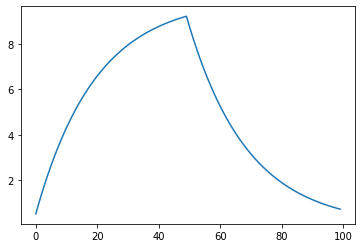

In [ ]:
'''
#Debuggin Cell
num_step = np.arange(0,100,1 )
#print(len(num_step))
plt.plot(num_step,voltageOut)
'''

In [ ]:
'''
#Debugging Cell
# Verifying that returns take you out of the if

def verif_return(action, go_out):
  if go_out == 1:
    return 10
  
  if action == 1:
    print("I have an action of 1")
  else:
    print("I have an action of 0")
  return 0

action = 0
go_out = 1

z = verif_return(action,go_out)
print(z)

#indeed makes you out of the loop
'''

10


In [ ]:
'''
# Debuggin Cell
# Veryging Assert
action = 5
err_msg = "%r (%s) invalid" % (action, type(action))
assert action == 6 or action ==4, err_msg
# The error indicates that works
'''

In [ ]:
'''
#Debugging Cell
# Condition if not evaluation
val = 10
max_val = 12
evaluator = bool(val > max_val)
print("evaluator is %r" % (evaluator))
if not evaluator:
  print("Ich bin drin")
'''

evaluator is False
Ich bin drin


In [ ]:
# Environment Creationg using Gym Libraries
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

class OneQuadrant(gym.Env):
  """
  Description:
    The following environment represents a LR circuit with 
    a control switch.
    The system always starts with the Inductor Not charge
    The goal is to keep the charge at the output in a specific
    value, by open or closing the switch, i.e., by controlling
    the charge in the inductor

  Observation:
    Type: Box(1)
    Num   Observation             Min   Max
    0     Voltage at the output   0     10

  Actions:
    Type: Discrete (2)
    Num     Action
    0       Open the Switch
    1       Close the Switch

  Reward:
    The reward will be calculated according the difference 
    between the reference value and the actual observation
    Maximun reward available is 1, worst reward availables are 0.5
    reward = 1 - abs(self.referenceVal - self.voltageOut)/self.voltageIn

  Starting State:
    Always start with Voltage 0

  Episode Termination:
    Episode Length is greater than 100

  """

  def __init__(self):
    self.inductor = 10.0
    self.resistor = 50.0
    self.voltageIn = 10.0
    self.voltageOut = 0.0
    #self.tau = self.inductor/self.resistor
    self.timeStep = 0.04
    self.i = 0.0
    self.i_dot = 0.0
    self.referenceVal = 5.0 # Desired Value

    self.action_space = spaces.Discrete(2)

    #Limits of the observation space
    VMAX = 10.0
    VMIN = 0.0

    self.observation_space = spaces.Box(VMIN, VMAX, dtype = np.float32)

    #Seed for random seed
    self.seed()   

    self._state = 0.0
    self._episode_ended = False
    self.steps_episode = 0 

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def step(self, action):

    # Verifying that the action is valid
    err_msg = "%r (%s) invalid" % (action, type(action))
    assert self.action_space.contains(action), err_msg
  
    if self._episode_ended:
      # Ignore the current action and start a new episode
      return self.reset()

    #Equation / modelling of the system
    if action == 1:
      self.i_dot = self.voltageIn/self.inductor - (self.resistor/self.inductor)*self.i
      #using integration euler procedure
      self.i +=  self.timeStep * self.i_dot
      self.voltageOut = self.i * self.resistor
      self._state = self.voltageOut
    elif action == 0:
      self.i_dot = -(self.resistor/self.inductor)*self.i
      self.i += self.timeStep * self.i_dot
      self.voltageOut = self.i * self.resistor
      self._state = self.voltageOut
    else:
      raise ValueError('action should be 0 or 1')

    # Reward definition
    # R = 1 - abs(w - y)/maxVal
    reward = 1 - abs(self.referenceVal - self.voltageOut)/self.voltageIn
    # count steps in the episode
    self.steps_episode += 1

    # Evaluation for episode ending
    if self.steps_episode > 100:
      self._episode_ended = True
  
    return self._state, reward, self._episode_ended, {}

  def _reset(self):
    self._state = 0.0
    self._episode_ended = False
    self.i = 0.0
    self.i_dot = 0.0
    self.steps_episode = 0

    return self._state
    
   
    

In [ ]:
#env = suite_gym.load(OneQuadrant)

TypeError: ignored

#Line of Separation of environments

In [ ]:
#Environment Creation
import math
class OneQuadrant(py_environment.PyEnvironment):
  def __init__(self):
    self.inductor = 10.0
    self.resistor = 50.0
    self.voltageIn = 10.0
    self.voltageOut = 0.0
    #self.tau = self.inductor/self.resistor
    self.timeStep = 0.04
    self.i = 0.0
    self.i_dot = 0.0
    self.referenceVal = 5.0

    # Function regarding the specs of our Environment
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum = 0, maximum = 1, name='action'
    )
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.float32, minimum = 0, name = 'observation'
    )

    self._state = 0.0
    self._episode_ended = False
    self.steps_episode = 0

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = 0.0
    self._episode_ended = False
    self.i = 0.0
    self.i_dot = 0.0
    self.steps_episode = 0

    # from trajectories, put the vector to 0
    return ts.restart(np.array([self._state], dtype=np.float32))

  def _step(self, action):
    # Verifying that the action is valid
    err_msg = "%r (%s) invalid" % (action, type(action))
    assert action == 0 or action == 1, err_msg
  
    if self._episode_ended:
      # Ignore the current action and start a new episode
      return self.reset()

    #Equation / modelling of the system
    if action == 1:
      self.i_dot = self.voltageIn/self.inductor - (self.resistor/self.inductor)*self.i
      #using integration euler procedure
      self.i +=  self.timeStep * self.i_dot
      self.voltageOut = self.i * self.resistor
      self._state = self.voltageOut
    elif action == 0:
      self.i_dot = -(self.resistor/self.inductor)*self.i
      self.i += self.timeStep * self.i_dot
      self.voltageOut = self.i * self.resistor
      self._state = self.voltageOut
    else:
      raise ValueError('action should be 0 or 1')
   
    '''
    #we declare done to get out of loop
    correct_space = bool(
      self.voltageOut < self.v_threshold and
      self.voltageOut > self.v_thresholdNeg
    )
    # if we are not in the correct zone,
    if not correct_space:
      reward = -1.0
    elif correct_space: # if we ar ein the correct zone
      reward = 0.0
    ''' 
    # Reward definition
    # R = 1 - abs(w - y)/maxVal
    reward = 1 - abs(self.referenceVal - self.voltageOut)/self.voltageIn
    # count steps in the episode
    self.steps_episode += 1

    # Evaluation for episode ending
    if self.steps_episode > 100:
      self._episode_ended = True
      
    if not self._episode_ended:
      return ts.transition(np.array([self._state], dtype=np.float32), reward, discount=1)
    else:
      return ts.termination(np.array([self._state], dtype=np.float32), reward)
      

In [ ]:
'''
# Initialization of the environment
environment = OneQuadrant()
print('action_spec: ', environment.action_spec())
print('time_step_spec.observation:', environment.time_step_spec().observation)
print('time_step_spec.step_type: ', environment.time_step_spec())
'''

action_spec:  BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=1)
time_step_spec.observation: BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=3.4028234663852886e+38)
time_step_spec.step_type:  TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=3.4028234663852886e+38),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})


In [ ]:
'''
open_switch_action = np.array(0, dtype = np.int32)
close_switch_action = np.array(1, dtype = np.int32)
'''

In [ ]:
'''
# Test for only one step with close_switch_action
time_step = environment.reset()
print(time_step)
# expected observation in 0, with reward of 0, because
# Simulation has not startet
'''

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


In [ ]:
'''
#debugging cell to test 2 more evaluations
time_step = environment.step(close_switch_action)
print(time_step)
time_step = environment.step(close_switch_action)
print(time_step)
'''

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([2.], dtype=float32),
 'reward': array(0.7, dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([3.6], dtype=float32),
 'reward': array(0.86, dtype=float32),
 'step_type': array(1, dtype=int32)})


In [ ]:
'''
# Test for steps
time_step = environment.reset() # initialize the environment
print(time_step)
for _ in range(10):
  time_step = environment.step(close_switch_action)
  print(time_step)
'''

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([2.], dtype=float32),
 'reward': array(0.7, dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([3.6], dtype=float32),
 'reward': array(0.86, dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([4.88], dtype=float32),
 'reward': array(0.988, dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([5.904], dtype=float32),
 'reward': array(0.9096, dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([6.7232], dtype=float32),
 'reward': array(0.82768, dtype=float32),
 'ste

In [ ]:
'''
# Test with while is last
time_step = environment.reset() # initialize the environment
print(time_step)
while not time_step.is_last():
  time_step = environment.step(close_switch_action)
  print(time_step)

'''

In [ ]:
'''
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(100):
  time_step = environment.step(close_switch_action)
  cumulative_reward += time_step.reward

time_step = environment.step(open_switch_action)
print(cumulative_reward)
cumulative_reward += time_step.reward
print('Final Reward =', cumulative_reward)
'''

In [ ]:
#Debugging Cell
dummy_vector = np.zeros([10,]) +0.5
print(dummy_vector)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [ ]:
#Debugging Cell
time_step = environment.reset()
print(time_step.observation + 1)

[1.]


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
53.095993
Final Reward = 53.595993


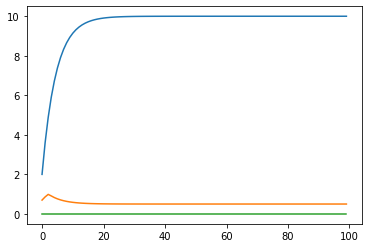

In [ ]:
#Test having 50 close switch actions
# and 50 non close switch actions
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward
total_reward = np.zeros([100,])
input_vector = np.zeros([100,]) + 0.5
output_vector = np.zeros([100,])
time_vector = np.zeros([100,])

for i in range(100):
  time_vector[i] = i
  if time_step.observation > 11:
    time_step = environment.step(open_switch_action)
    input_vector[i] = 1
  else:
    time_step = environment.step(close_switch_action)
    input_vector[i] = 0
  
  #print(time_step)
  total_reward[i] = time_step.reward
  output_vector[i] = time_step.observation
  cumulative_reward += time_step.reward

#time_step = environment.step(open_switch_action)
print(cumulative_reward)
cumulative_reward += time_step.reward
print('Final Reward =', cumulative_reward)

#Plotting
plt.figure(1)
plt.plot(time_vector, output_vector)
plt.plot(time_vector, total_reward)
plt.plot(time_vector, input_vector)

In [ ]:
total_reward.mean()

0.5309599989652634